In [ ]:
!pip install torch torchvision opencv-python numpy ultralytics inference_sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
# "/content/gdrive/My Drive/videoplayback.mp4"

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### YOLOv10


0: 384x640 14 persons, 179.6ms
Speed: 5.5ms preprocess, 179.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


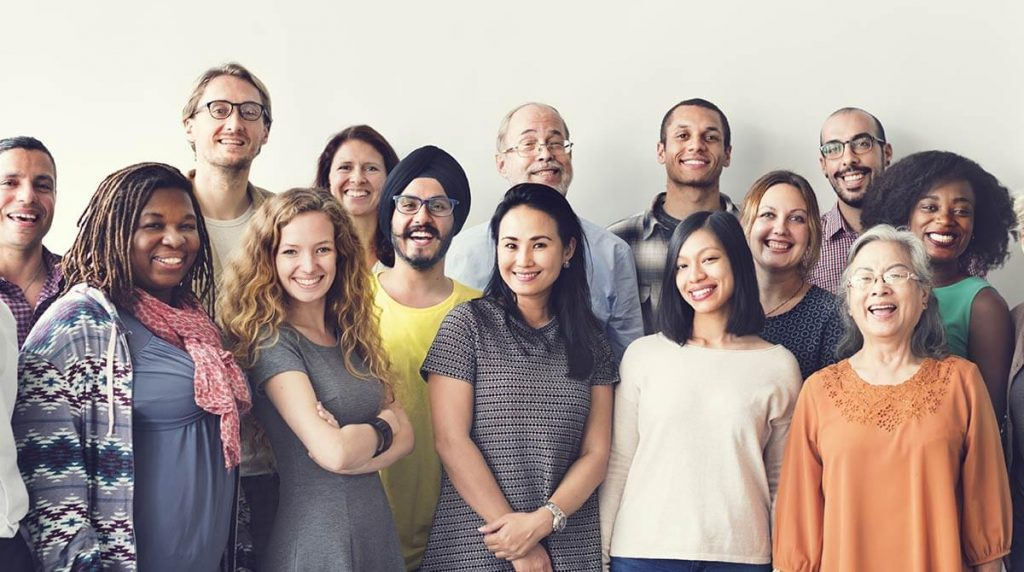

Total number of persons detected: 14


In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# Load a pre-trained YOLOv10n model
mod = YOLO("yolov10n.pt")

# Load the image
image_path = "/content/gdrive/My Drive/sample_people_image.jpg"
image = cv2.imread(image_path)

# Run inference on the image
results = mod(image)

# Count persons
person_count = sum(1 for result in results for box in result.boxes if mod.names[int(box.cls[0])] == 'person')

# Create a copy of the original image for displaying the count
display_image = image.copy()

# Display the total count on the image
cv2.putText(display_image, f'Total Persons: {person_count}', (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Display the result
cv2_imshow(image)
# cv2.imshow('Detected Persons', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the image with annotations
cv2.imwrite('output_image_with_count.jpg', image)

# Print the total count
print(f"Total number of persons detected: {person_count}")

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np

# Load the YOLOv10 model
model = YOLO('yolov10n.pt')

# Open the video file
video_path = "/content/gdrive/My Drive/videoplayback.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Set start and end frames
start_time = 14  # seconds
end_time = 32    # seconds
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Initialize people count
total_people = 0
frame_count = 0

# Process frames
for frame_num in range(start_frame, end_frame + 1):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()

    if not ret:
        break

    # Run YOLOv10 inference on the frame
    results = model(frame)

    # Count people in the current frame
    people_in_frame = sum(1 for box in results[0].boxes if box.cls == 0)  # Class 0 is 'person'
    total_people += people_in_frame
    frame_count += 1

    # Plotting video frame
    annotated_frame = results[0].plot()
    cv2_imshow(annotated_frame)

    # For manual stopping
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Calculate average number of people
average_people = total_people / frame_count if frame_count > 0 else 0

print(f"Average number of people detected: {average_people:.2f}")

# Release resources
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Clear that the pre-trained weights of YOLOv10 on COCO doesn't work
print(average_people)

0.037694013303769404


### Trying with Roboflow api of People Counting model
Model:- people-detection-o4rdr

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt

# Initialize the InferenceHTTPClient
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="sClYxGfAIAnudf2mPNP3"
)

In [ ]:
# Perform inference on the image
result = CLIENT.infer("/content/gdrive/My Drive/sample_people_image.jpg", model_id="people-detection-o4rdr/7")

In [ ]:
# Count the number of predictions (people detected)
num_predictions = len(result['predictions'])

In [ ]:
print(num_predictions)

5


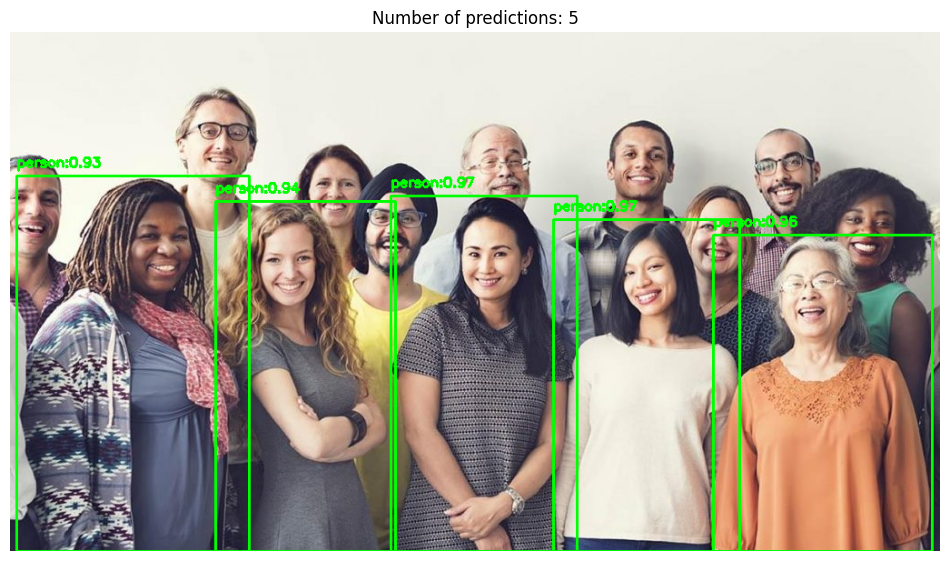

In [ ]:
# Load the image using OpenCV
image = cv2.imread("/content/gdrive/My Drive/sample_people_image.jpg")
height, width, _ = image.shape

# Extract prediction details and draw bounding boxes
for prediction in result['predictions']:
    x = int(prediction['x'] - prediction['width'] / 2)
    y = int(prediction['y'] - prediction['height'] / 2)
    w = int(prediction['width'])
    h = int(prediction['height'])

    # Draw the bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    label = f"{prediction['class']}:{prediction['confidence']:.2f}"
    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert the image from BGR to RGB (OpenCV uses BGR by default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the size of the output image
plt.figure(figsize=(12, 8))

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.title(f"Number of predictions: {num_predictions}")
plt.show()

### Movement tracking with depth estimation and adaptive thresholding

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import urllib.request
import os
import matplotlib.pyplot as plt

# Download the model file if it doesn't exist
model_path = "/content/gdrive/My Drive/ESPCN_x2.pb"
if not os.path.exists(model_path):
    url = "https://github.com/fannymonori/TF-ESPCN/blob/master/export/ESPCN_x2.pb"
    urllib.request.urlretrieve(url, model_path)
    print("Model downloaded successfully.")

def analyze_movement(frame1, frame2, frame3):
    diff1 = cv2.absdiff(frame1, frame2)
    diff2 = cv2.absdiff(frame2, frame3)
    consistent_diff = cv2.bitwise_and(diff1, diff2)
    return consistent_diff

def estimate_crowd_density(movement_mask):
    moving_pixels = np.sum(movement_mask > 0)
    total_pixels = movement_mask.size
    movement_percentage = (moving_pixels / total_pixels) * 100
    return movement_percentage

# Load the super resolution model
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel(model_path)
sr.setModel("espcn", 2)  # 2x upscaling

# Video path
video_path = "/content/gdrive/My Drive/videoplayback.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Set start and end frames
start_time, end_time = 14, 32  # seconds
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Parameters
initial_movement_threshold = 35
density_scale_factor = 50
rolling_average_window = 10

estimated_people_list = []
frame_numbers = []

# Read the first three frames
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
_, frame1 = cap.read()
_, frame2 = cap.read()
_, frame3 = cap.read()

# Increase resolution using DNN Super Resolution
frame1 = sr.upsample(frame1)
frame2 = sr.upsample(frame2)
frame3 = sr.upsample(frame3)

# Convert frames to grayscale
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

# Process frames
for frame_num in range(start_frame + 3, end_frame + 1):
    # Analyze movement
    movement = analyze_movement(gray1, gray2, gray3)

    # Adaptive thresholding
    movement_threshold = np.mean(movement) + 2 * np.std(movement)
    movement_mask = (movement > movement_threshold).astype(np.uint8) * 255

    # Estimate crowd density
    density = estimate_crowd_density(movement_mask)
    estimated_people = int(density * density_scale_factor)

    estimated_people_list.append(estimated_people)
    frame_numbers.append(frame_num)

    # Rolling average
    if len(estimated_people_list) > rolling_average_window:
        avg_estimated_people = int(np.mean(estimated_people_list[-rolling_average_window:]))
    else:
        avg_estimated_people = estimated_people

    # Visualize (optional)
    display_frame = cv2.resize(frame3, (frame3.shape[1]//2, frame3.shape[0]//2))  # Downscale for display
    cv2.putText(display_frame, f"Estimated People: {avg_estimated_people}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(display_frame)
    cv2_imshow(cv2.resize(movement_mask, (movement_mask.shape[1]//2, movement_mask.shape[0]//2)))  # Downscale for display

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Shift frames
    gray1 = gray2
    gray2 = gray3

    # Read next frame
    ret, frame3 = cap.read()
    if not ret:
        break
    frame3 = sr.upsample(frame3)  # Increase resolution of new frame
    gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

    # Periodic baseline reset (every 30 frames)
    if frame_num % 30 == 0:
        _, frame1 = cap.read()
        _, frame2 = cap.read()
        frame1 = sr.upsample(frame1)
        frame2 = sr.upsample(frame2)
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Plot the estimated people count over time
plt.figure(figsize=(12, 6))
plt.plot(frame_numbers, estimated_people_list)
plt.title('Estimated People Count Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Estimated People Count')
plt.savefig("People count vs Time.png")
plt.show()

# Calculate the average number of people
average_people_estimate = np.mean(estimated_people_list)

# Release resources
cap.release()
cv2.destroyAllWindows()

In [23]:
print(int(average_people_estimate))

225


### Movement analysis with enhanced resolution

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import urllib.request
import os
import matplotlib.pyplot as plt

model_path = "/content/gdrive/My Drive/ESPCN_x2.pb"
if not os.path.exists(model_path):
    url = "https://github.com/fannymonori/TF-ESPCN/blob/master/export/ESPCN_x2.pb"
    urllib.request.urlretrieve(url, model_path)
    print("Model downloaded successfully.")

def analyze_movement(frame1, frame2, frame3, threshold):
    diff1 = cv2.absdiff(frame1, frame2)
    diff2 = cv2.absdiff(frame2, frame3)
    consistent_diff = cv2.bitwise_and(diff1, diff2)
    _, movement_mask = cv2.threshold(consistent_diff, threshold, 255, cv2.THRESH_BINARY)
    return movement_mask

def estimate_crowd_density(movement_mask):
    moving_pixels = np.sum(movement_mask > 0)
    total_pixels = movement_mask.size
    movement_percentage = (moving_pixels / total_pixels) * 100
    return movement_percentage

# Load the super resolution model
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel(model_path)
sr.setModel("espcn", 2)  # 2x upscaling

# Video path
video_path = "/content/gdrive/My Drive/videoplayback.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Set start and end frames
start_time, end_time = 14, 32  # seconds
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Parameters to adjust
movement_threshold = 35
density_scale_factor = 50

total_density = 0
frame_count = 0

estimated_people_list = []
frame_numbers = []

# Read the first three frames
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
_, frame1 = cap.read()
_, frame2 = cap.read()
_, frame3 = cap.read()

# Increase resolution using DNN Super Resolution
frame1 = sr.upsample(frame1)
frame2 = sr.upsample(frame2)
frame3 = sr.upsample(frame3)

# Convert frames to grayscale
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

# Process frames
for frame_num in range(start_frame + 3, end_frame + 1):
    # Analyze movement
    movement_mask = analyze_movement(gray1, gray2, gray3, movement_threshold)

    # Estimate crowd density
    density = estimate_crowd_density(movement_mask)
    estimated_people = int(density * density_scale_factor)

    total_density += density
    frame_count += 1

    estimated_people_list.append(estimated_people)
    frame_numbers.append(frame_num)

    # Plotting video frames and masked frames
    display_frame = cv2.resize(frame3, (frame3.shape[1]//2, frame3.shape[0]//2))  # Downscale for display
    cv2.putText(display_frame, f"Estimated People: {estimated_people}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(display_frame)
    cv2_imshow(cv2.resize(movement_mask, (movement_mask.shape[1]//2, movement_mask.shape[0]//2)))  # Downscale for display

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Shift frames
    frame1, frame2 = frame2, frame3
    gray1, gray2 = gray2, gray3

    # Read next frame
    ret, frame3 = cap.read()
    if not ret:
        break
    frame3 = sr.upsample(frame3)  # Increase resolution of new frame
    gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

# Calculate average density and estimated people count
average_density = total_density / frame_count if frame_count > 0 else 0
average_estimated_people = int(average_density * density_scale_factor)

print(f"Average estimated number of people: {average_estimated_people}")

# Plot the estimated people count over time
plt.figure(figsize=(12, 6))
plt.plot(frame_numbers, estimated_people_list)
plt.title('Estimated People Count Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Estimated People Count')
plt.savefig("People count vs Time (Fixed Threshold).png")
plt.show()

# Release resources
cap.release()
cv2.destroyAllWindows()

In [ ]:
print(average_estimated_people)

108


### Movement analysis without enhancement and fixed thresholding

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def analyze_movement(frame1, frame2, frame3, threshold):
    # Compute absolute difference between consecutive frames
    diff1 = cv2.absdiff(frame1, frame2)
    diff2 = cv2.absdiff(frame2, frame3)

    # Bitwise AND operation to get only consistent differences
    consistent_diff = cv2.bitwise_and(diff1, diff2)

    # Threshold the difference
    _, movement_mask = cv2.threshold(consistent_diff, threshold, 255, cv2.THRESH_BINARY)

    return movement_mask

def estimate_crowd_density(movement_mask):
    # Calculate the percentage of moving pixels
    moving_pixels = np.sum(movement_mask > 0)
    total_pixels = movement_mask.size
    movement_percentage = (moving_pixels / total_pixels) * 100

    return movement_percentage

# Video path
video_path = "/content/gdrive/My Drive/videoplayback.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Set start and end frames
start_time, end_time = 14, 32  # seconds
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Parameters to adjust
movement_threshold = 35
density_scale_factor = 50

total_density = 0
frame_count = 0

# Lists for plotting
estimated_people_list = []
frame_numbers = []

# Read the first three frames
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
_, frame1 = cap.read()
_, frame2 = cap.read()
_, frame3 = cap.read()

# Convert frames to grayscale
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

# Process frames
for frame_num in range(start_frame + 3, end_frame + 1):
    # Analyze movement
    movement_mask = analyze_movement(gray1, gray2, gray3, movement_threshold)

    # Estimate crowd density
    density = estimate_crowd_density(movement_mask)
    estimated_people = int(density * density_scale_factor)

    total_density += density
    frame_count += 1

    # Store data for plotting
    estimated_people_list.append(estimated_people)
    frame_numbers.append(frame_num)

    # Visualize (optional)
    cv2.putText(frame3, f"Estimated People: {estimated_people}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(frame3)
    cv2_imshow(movement_mask)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Shift frames
    gray1 = gray2
    gray2 = gray3

    # Read next frame
    ret, frame3 = cap.read()
    if not ret:
        break
    gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

# Calculate average density and estimated people count
average_density = total_density / frame_count if frame_count > 0 else 0
average_estimated_people = int(average_density * density_scale_factor)

# Plot the estimated people count over time
plt.figure(figsize=(12, 6))
plt.plot(frame_numbers, estimated_people_list)
plt.title('Estimated People Count Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Estimated People Count')
plt.savefig("People count vs Time (No Enhancement and Fixed Threshold).png")
plt.show()

# Release resources
cap.release()
cv2.destroyAllWindows()

In [ ]:
print(average_estimated_people)

118
